In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39279")
client

<Client: 'tcp://127.0.0.1:39279' processes=8 threads=40, memory=157.39 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:39279' processes=0 threads=0, memory=0 B>

In [43]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
import os.path as op
import os
import gcm_filters
# import xrft
import gsw
import time
# from scipy.interpolate import PchipInterpolator, interp1d
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from MITgcmutils import jmd95
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [36]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'
spec = '/tank/spectre/tuchida/TWA'

In [5]:
dnf = 2160

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
sstart = 23
send = 49
nremap = 50
dnf = 2160
nchk = 20
nhskp = 3
nbskp = 2
nremap = 80
nfile = 73

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [37]:
ystart = ySstart
itime = 1421280
dsbathy = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                 % (0,year)), 
                         grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                         iters=itime,
                         prefix=['diag_ocnTave'], delta_t=2e2,
                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                              YG=slice(ystart-12**-1,yend+2*12**-1)
                             ).chunk({'XC':xchunk,'XG':xchunk,
                                 'YC':ychunk,'YG':ychunk})
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,year)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=itime,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                          YG=slice(ystart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})


nmembs = np.arange(36,60)

for memb in nmembs:
    if memb == 36:
        dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,memb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).reset_coords(drop=True).isel(time=0)
        
    else:
        dsz = xr.concat([dsz, xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                                   % (year,memb,itime))
                                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                YG=slice(ystart-12**-1,yend+2*12**-1)
                                               ).reset_coords(drop=True).isel(time=0)
                        ], 'nmemb')
        
dsmnb = xr.open_zarr(op.join(spec,'5Dave/run%4d/HorDynb_%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                         YG=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dsmnb.coords['delta'] = dsz.delta

dsptb = xr.open_zarr(op.join(spec,'5Dave/run%4d/PTracerb/%010d/' 
                            % (year,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dsptb.coords['delta'] = dsz.delta

dstb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Tracerb/%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dstb.coords['delta'] = dsz.delta

dszb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Zetab_%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                         YG=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dszb.coords['delta'] = dsz.delta

dsTp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyTrFlx/explicit/%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)

/tmp/ipykernel_4533/809451950.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/'
/tmp/ipykernel_4533/809451950.py:34: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=Fa

In [38]:
mask = ~dszb.dzetab.where(dszb.dzetab!=0.).where(dszb.zetab!=0.
                                              ).where(dstb.that!=0.
                                                     ).where(dstb.shat!=0.
                                                            ).where(dsptb.P0hat!=0
                                                                   ).where(dsptb.P1hat!=0
                                                                          ).where(dsptb.P2hat!=0
                                                                                 ).where(dsptb.P3hat!=0
                                                                                        ).where(dsTp.upTphat!=0.
                                                                                               ).where(dsTp.upSphat!=0.
                                                                                                      ).where(dsTp.vpTphat!=0.
                                                                                                             ).where(dsTp.vpSphat!=0.
                                                                                                                    ).to_masked_array().mask
wet_mask = xr.DataArray(np.zeros((len(dsz.YC),len(dsz.XC),len(dsz.delta_outer))),
                        dims=['YC','XC','delta_outer'],
                        coords={'YC':dsz.YC,'XC':dsz.XC,
                                'delta_outer':dsz.delta_outer}
)
wet_mask[1:-1] = mask[1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'delta_outer':10})

In [39]:
grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'delta','outer':'delta_outer'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   delta --> outer
  * outer    delta_outer --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center

In [40]:
area = (grid.interp(ds.dxG,'Y',boundary='extend') 
        * grid.interp(ds.dyG,'X',boundary='extend')
       )
area

<xarray.DataArray (YC: 783, XC: 1000)>
dask.array<mul, shape=(783, 1000), dtype=float32, chunksize=(400, 250), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08

In [41]:
dxw = xr.DataArray(ds.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(ds.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(ds.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(ds.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

In [44]:
filter_scale = 50e3    # 50km
filt_mask = wet_mask.chunk({'YC':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
            'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
            'area': area.chunk({'YC':-1,'XC':-1}), 
            'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
            'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
        }
    )
gauss_filter

Filter(filter_scale=50000.0, dx_min=array(6134.034, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [46]:
l = 23
nC = 10
rAc = (ds.rA.where(wet_mask!=0.)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC}, boundary='trim')
      ).sum(skipna=False) 

In [47]:
upThat_sm = gauss_filter.apply((dsTp.upTphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpThat_sm = gauss_filter.apply((dsTp.vpTphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

uT = ((upThat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vT = ((vpThat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()

In [48]:
maskC = uT.to_masked_array().mask
maskC = np.ma.masked_array(vT.to_masked_array(),maskC).mask

In [6]:
# make sure the eigen values are arranged by magnitude 
# (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [14]:
year = 1967
itime = 1421280
K = xr.open_zarr(op.join(spec,
                         '5Dave/run%4d/Diff-tensor/explicit/no-skipNaN/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                         % (year,50,10,ySstart,yend,itime))
                ).K.transpose('delta_outer','YC','XC','row','col')
Kt = K.transpose('delta_outer','YC','XC','col','row')
print(K, Kt)
Sym = .5*xr.DataArray(K.data + Kt.data, dims=K.dims,
                      coords=K.coords
                     ).chunk({'delta_outer':1,'row':-1,'col':-1})
Sym

<xarray.DataArray 'K' (delta_outer: 55, YC: 78, XC: 100, row: 2, col: 2)>
dask.array<transpose, shape=(55, 78, 100, 2, 2), dtype=float64, chunksize=(28, 39, 50, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.4 263.2 264.1 265.0 ... 345.9 346.7 347.6
  * YC           (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: row, col <xarray.DataArray 'K' (delta_outer: 55, YC: 78, XC: 100, col: 2, row: 2)>
dask.array<transpose, shape=(55, 78, 100, 2, 2), dtype=float64, chunksize=(28, 39, 50, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.4 263.2 264.1 265.0 ... 345.9 346.7 347.6
  * YC           (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: col, row


,Array,Chunk
Bytes,13.09 MiB,60.94 kiB
Shape,"(55, 78, 100, 2, 2)","(1, 39, 50, 2, 2)"
Count,1449 Tasks,220 Chunks
Type,float64,numpy.ndarray


In [19]:
eigvals, eigvecs = xr.apply_ufunc(eigen, Sym, 
                                  input_core_dims=[['row','col']],
                                  vectorize=True,
                                  dask="parallelized",
                                  output_core_dims=[['ii'], ['k','ii']],
                                  output_sizes={'ii':2, 'k':2}
                                 )
eigvecs.shape

/tmp/ipykernel_4533/709454846.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  eigvals, eigvecs = xr.apply_ufunc(eigen, Sym,


(55, 78, 100, 2, 2)

In [27]:
eval_par = xr.DataArray(eigvals[...,1].data, dims=['delta_outer','YC','XC'],
                        coords={'delta_outer':K.delta_outer.data,'YC':K.YC.data,'XC':K.XC.data},
                        name='par')
eval_per = xr.DataArray(eigvals[...,0].data, dims=['delta_outer','YC','XC'],
                        coords={'delta_outer':K.delta_outer.data,'YC':K.YC.data,'XC':K.XC.data},
                        name='per')

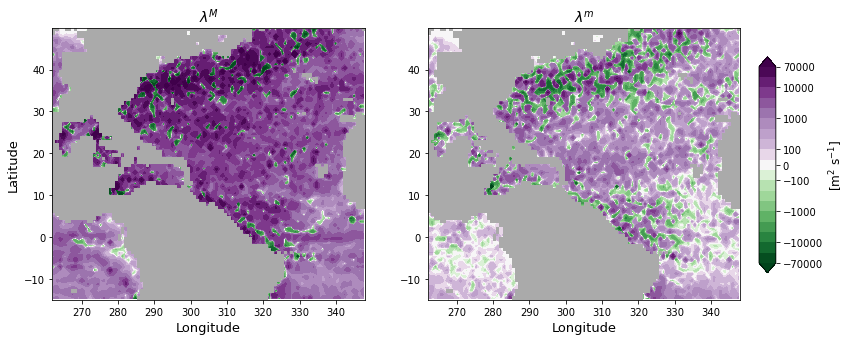

In [62]:
linthresh = 1e2
levs = -np.flip(np.logspace(np.log10(1e4),np.log10(7e4),num=3)[1:])
levs = np.concatenate((levs,-np.flip(np.logspace(np.log10(linthresh),np.log10(1e4),num=7))))
levs = np.concatenate((levs,np.linspace(-linthresh,linthresh,4)[1:-1]))
levs = np.concatenate((levs,np.logspace(np.log10(linthresh),np.log10(1e4),num=7)))
levs = np.concatenate((levs,np.logspace(np.log10(1e4),np.log10(7e4),num=3)[1:]))


fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)

im0 = ax1.contourf(K.XC.data, K.YC.sel(YC=slice(ySstart,yend)).data, 
                   eval_par.isel(delta_outer=l).sel(YC=slice(ySstart,yend)), 
                   # vmin=-7e4, vmax=7e4, rasterized=True, 
                   cmap='PRGn_r',
                   levels = levs,
                   extend='both',
                   norm=clr.SymLogNorm(linthresh=linthresh)
                  )
im1 = ax2.contourf(K.XC.data, K.YC.sel(YC=slice(ySstart,yend)).data, 
                   eval_per.isel(delta_outer=l).sel(YC=slice(ySstart,yend)), 
                   # vmin=-7e4, vmax=7e4, rasterized=True
                   cmap='PRGn_r', 
                   levels = levs,
                   extend='both',
                   norm=clr.SymLogNorm(linthresh=linthresh)
                  )

for c in im0.collections:
    c.set_rasterized(True)
for c in im1.collections:
    c.set_rasterized(True)

ax1.pcolormesh(K.XC.data, K.YC.sel(YC=slice(ySstart,yend)).data, 
               np.ma.masked_array(maskC, ~maskC),
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax2.pcolormesh(K.XC.data, K.YC.sel(YC=slice(ySstart,yend)).data, 
               np.ma.masked_array(maskC, ~maskC),
               vmin=0, vmax=3, cmap='binary', rasterized=True)

ax1.set_title(r"$\lambda^M$", fontsize=14)
ax2.set_title(r"$\lambda^m$", fontsize=14)

ax1.set_xlabel(r"Longitude", fontsize=13)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar = fig.colorbar(im0, orientation='vertical', cax=cbax,
                    ticks=[-7e4,-1e4,-1e3,-linthresh,0,linthresh,1e3,1e4,7e4])
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/Kappa-eigens_5Dave-delta=%2d_1967-Jan-03.pdf' % l))

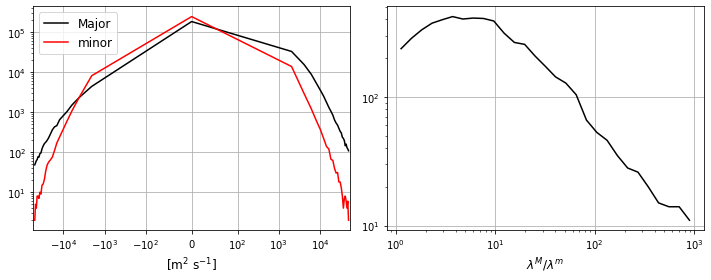

In [ ]:
bins = np.linspace(-5e4, 5e4, 50)
par = xhist(eval_par, bins=[bins])
per = xhist(eval_per, bins=[bins])
ratio = xr.DataArray(np.abs(eigvals.isel(delta_outer=l)[...,1])/np.abs(eigvals.isel(delta_outer=l)[...,0]), 
                     name='ratio')
aniso = xhist(ratio, bins=[np.logspace(0,3,30)])


fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

ax1.plot(par.par_bin, par, 'k', label='Major')
ax1.plot(per.per_bin, per, 'r', label='minor')

ax2.loglog(aniso.ratio_bin, aniso, 'k')

ax1.set_yscale('log')
ax1.set_xscale('symlog', linthresh=1e2)
ax1.set_xlabel(r"[m$^2$ s$^{-1}$]", fontsize=12)
ax2.set_xlabel(r"$\lambda^M/\lambda^m$", fontsize=12)
ax1.grid(True)
ax2.grid(True)
ax1.legend(loc='upper left', fontsize=12)

/tank/users/tuchida/miniconda3/envs/xlayers/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


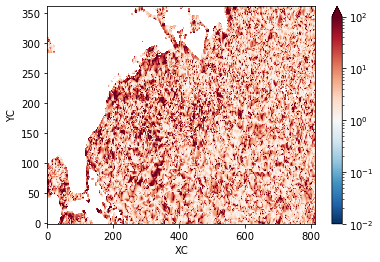

In [15]:
(np.abs(eval_par)/np.abs(eval_per)).plot(norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                                         cmap='RdBu_r')

In [16]:
years = np.arange(2008,2013,dtype=int)
ntimes = np.arange(7886160,8672400+dnf,dnf).reshape(len(years),nfile)
dd = 0
yystart = 1
ntimes[yystart,dd]

8043840

In [17]:
yy = yystart
xlim = [270,340]

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd:]
        ystart = yNstart
    else:
        mtimes = ntimes[yy]
        ystart = yNstart
    for itime in mtimes:

        K = xr.open_dataset(op.join(ddir,
                        '5Dave/run%4d/Kappas_isig%2d-%2d_nhskip3_nbskip2_%010d.nc' 
                                    % (year,sstart,send,itime))
                           ).K.sel(XC=slice(xlim[0],xlim[1])).isel(sig=1)
        Kt = K.transpose('YC','XC','col','row')
        Sym = .5*(K.data + Kt.data)
        
        eigvals, eigvecs = xr.apply_ufunc(eigen, Sym, 
                                          input_core_dims=[['i','j']],
                                          vectorize=True, 
                                          output_core_dims=[['ii'], ['k','ii']]
                                         )
        eval_par = xr.DataArray(eigvals[:,:,1], dims=['YC','XC'],
                                coords={'YC':K.YC.data,
                                        'XC':K.XC.sel(XC=slice(xlim[0],xlim[1])).data})
        eval_per = xr.DataArray(eigvals[:,:,0], dims=['YC','XC'],
                                coords={'YC':K.YC.data,
                                        'XC':K.XC.sel(XC=slice(xlim[0],xlim[1])).data})

        dsave = eval_par.to_dataset(name='par')
        dsave['per'] = eval_per
        dsave.to_netcdf(op.join(ddir,
                                '5Dave/run%4d/Lambdas_isig%02d_nhskip%1d_nbskip%1d_%10d.nc' 
                                % (year,25,nhskp,nbskp,itime))
                       )
        dsave.close()
        
    yy += 1